# Assignment 1

In [1]:
!pip install nb_conda_kernels==2.2.2
!pip install matplotlib==3.1.1
!pip install scipy==1.3.1

  ERROR: Could not find a version that satisfies the requirement nb_conda_kernels==2.2.2 (from versions: none)
ERROR: No matching distribution found for nb_conda_kernels==2.2.2


  Using cached https://files.pythonhosted.org/packages/cc/eb/fd7a5f3c1484e8d2590ff94ca0b89941940a916394f719ab3bb7279e1970/matplotlib-3.1.1-cp36-cp36m-win_amd64.whl
  Found existing installation: matplotlib 2.2.2
    Uninstalling matplotlib-2.2.2:
      Successfully uninstalled matplotlib-2.2.2
  Found existing installation: scipy 1.1.0
    Uninstalling scipy-1.1.0:
      Successfully uninstalled scipy-1.1.0


### Import delle librerie

In [2]:
import os
import numpy as np
from time import time
from scipy.io import wavfile as wav

import matplotlib.pyplot as plt
import IPython.display as ipd

# Strumenti di classificazione
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix

# Feature audio avanzate
import librosa
import librosa.display as lid
from sklearn.preprocessing import scale

In [3]:
from google.colab import drive
drive.mount('/content/drive')

ModuleNotFoundError: No module named 'google.colab'

#Data Loader

1.   Carichiamo i file da disco
2.   Estraiamo la classe indicata nel nome del file
3.   Dividiamo le tracce in training set e test set
4.   Applichiamo una normalizzazione sulla base del training set






In [4]:
'/content/drive/My Drive/Digital Signal and Image Management/Esercitazioni/Esercitazione 2/recordings/'

'/content/drive/My Drive/Digital Signal and Image Management/Esercitazioni/Esercitazione 2/recordings/'

### Caricamento dati

In [0]:
# Segnaposto per feature extractor
def identity(input):
    return input

# Data loader
def load_data(feature_extractor=identity, normalize=True):

    labels = []
    features = []

    for f in sorted(os.listdir('/content/drive/My Drive/Digital Signal and Image Management/Esercitazioni/Esercitazione 2/recordings/')):
        if f.endswith('.wav'):
            # Carica file ed estraine le features
            _, signal = wav.read('/content/drive/My Drive/Digital Signal and Image Management/Esercitazioni/Esercitazione 2/recordings/' + f)
            cur_features = feature_extractor(signal)
            features.append(cur_features)

            # Categorie
            label = f.split('_')[0]
            labels.append(label)

    # X: features, y: labels
    X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.1, random_state=1)

    if normalize:
        eps = 0.001
        X_train = np.array(X_train)
        X_train_mean = X_train.mean(axis=0)
        X_train_std = X_train.std(axis=0)
        X_train = (X_train - X_train_mean + eps)/(X_train_std + eps)
        X_train = [row for row in X_train]

        X_test = [row for row in (np.array(X_test) - X_train_mean + eps)/(X_train_std + eps)]

    return X_train, X_test, y_train, y_test

# Funzioni di creazione delle Features

Definisco una funzione che elimina eventuali valori oltre il numero consentito (100) o aggiunge valori per arrivare al numero indicato

In [0]:
def crop(input, size = 100):
  #Salva nella variabile output il valore dell'input che arriva a 100 (size) o la dimensione originale nel caso sia minore di 100
  output = input[0:min(size, input.shape[0])]
  #Salva nella variabile output il valore restituito precedentemente + il valore che manca per arrivare (eventualmente) a 100
  output = np.concatenate((output, np.zeros(size - output.shape[0])))
  return output

Definisco deviazione standard del segnale

In [0]:
def sdev(input):
    return np.std(input, keepdims=True)

Definisco durata del segnale

In [0]:
def duration(input):
    return input.shape

Definisco Energia dell'input

In [0]:
#Dovrebbe sommare tutti i valori che trova nell'array-segnale
def energy(input):
    return np.sum((input*1.0)**2, keepdims=True)

Definisco media e media assoluta

In [0]:
def avg(input):
    return np.mean(input, keepdims=True)

def aavg(input):
    return np.mean(np.abs(input), keepdims=True)

Definisco MFCC

In [0]:
def mfcc(input, rate=8000, min_len=40, sampling=1):
    # Campiona i valori
    signal = input[::sampling]
    # Calcola coefficienti MFCC
    mfcc = librosa.feature.mfcc(signal*1.0, sr=int(rate/sampling))
    # Applica eventuali zeri aggiuntivi per raggiungere una lunghezza fissa
    pad_width = min_len - mfcc.shape[1]
    mfcc = np.pad(mfcc, pad_width=((0, 0), (0, pad_width)), mode='constant')
    # Appiattisci rappresentazione per uso con SVM
    mfcc = mfcc.flatten()
    return mfcc

Inserisco feature importanti in un unico vettore

In [0]:
def combo(input):
    return np.concatenate((aavg(input),sdev(input),duration(input),energy(input)))

# SVM

In [0]:
X_train, X_test, y_train, y_test = load_data(feature_extractor=combo)

Quanti esempi uso per il training? Quante dimensioni hanno le osservazioni (numero di features)?

In [14]:
print("la lunghezza è " + str(len(X_train)))
print("il numero di features è " + str(X_train[0].shape[0]))

la lunghezza è 1350
il numero di features è 4


Definisco una griglia di parametri su cui effettuare training del classificatore SVM per determinare l'ottimo

In [15]:
# Parametri da provare in cross validation
param_grid = {'C': [1e2, 5e2, 1e3],
          'gamma': [0.005, 0.01, 0.1, 0.5, 1.0], }

# Inizializzazione Support Vector Machine
clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'), param_grid, cv=2)

# Addestramento
t0 = time()
clf = clf.fit(X_train, y_train)
print("Addestramento completato in %0.3fs" % (time() - t0))

Addestramento completato in 2.936s


Seleziono la migliore combinazione di parametri

In [16]:
print("La migliore combinazione di parametri è: ")
print(" C: "+str(clf.best_estimator_.C))
print(" gamma: "+str(clf.best_estimator_.gamma))

La migliore combinazione di parametri è: 
 C: 1000.0
 gamma: 0.5


# Test del modello
Determino la bontà del modello appena creato sui valori di training

In [0]:
y_pred = clf.predict(X_test)

Classification Report

In [18]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.58      0.65      0.61        17
           1       0.33      0.40      0.36        10
           2       0.28      0.33      0.30        15
           3       0.53      0.42      0.47        19
           4       0.36      0.45      0.40        11
           5       0.44      0.29      0.35        14
           6       0.79      0.79      0.79        14
           7       0.80      0.42      0.55        19
           8       0.35      0.41      0.38        17
           9       0.32      0.43      0.36        14

    accuracy                           0.46       150
   macro avg       0.48      0.46      0.46       150
weighted avg       0.49      0.46      0.47       150



Matrice di confusione


[[11  0  0  0  0  0  0  0  0  6]
 [ 0  4  2  2  0  1  0  0  1  0]
 [ 2  1  5  3  0  0  0  0  2  2]
 [ 0  3  7  8  0  0  0  0  0  1]
 [ 1  1  1  1  5  2  0  0  0  0]
 [ 1  0  0  1  4  4  1  0  2  1]
 [ 0  0  0  0  0  0 11  1  2  0]
 [ 0  0  0  0  2  0  2  8  4  3]
 [ 0  2  2  0  3  2  0  1  7  0]
 [ 4  1  1  0  0  0  0  0  2  6]]


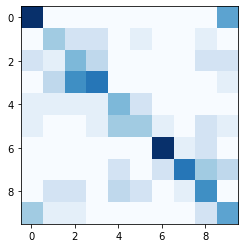

In [19]:
cm = confusion_matrix(y_test, y_pred)
print(cm)
plt.imshow(cm, cmap=plt.cm.Blues)

# Zero Crossing Rate - Assignment

Da definire per compito **Zero Crossing Rate**:
<br> Contare il numero di volte in cui il segnale attraversa lo zero.

**Possibile approccio**:


1.   Traslare il segnale di un'unità
2.   Confrontare punto a punto il segno (sign()) del segnale originale e di quello traslato
3.   Accumulare le evidenze dei cambi di segno






Definisco 2 possibili alternative, ne mostro l'efficacia di ognuna su una lista di valori di esempio e poi procedo ad applicarne una versione come feature nel dataset per valutare se c'è un miglioramento delle performance del classificatore.

In [4]:
#versione in cui scorro unico array
def zerocrossingrate(input):
    a = 0
    for x in range(1, len(input)):
        a = a + np.abs((np.sign(input[x])-np.sign(input[x-1])))
    return np.array(a/2).reshape(-1)

In [5]:
#versione in cui scorro due array e calcolo la differenza
def zerocrossingrate2(input):
    count = 0
    input2 = np.concatenate((np.zeros(1), input))
    for x in range(1, len(input)):
      count = count + np.abs((np.sign(input2[x]) - np.sign(input[x])))
    return np.array(count/2).reshape(-1)

Prova per valutare quante volte cambia il segno:

NB Dovrebbe farlo 10 volte

In [6]:
lista = [-1, 1, 2, 1, 1, -3, -4, 7, -8, 9, 10, -2, 1, -3, 5, 6, 7, -10]
a = np.array(lista)

In [7]:
print(zerocrossingrate(a))
print(zerocrossingrate2(a))

[10.]
[10.]


NB Dovrebbe farlo 7 volte

In [8]:
lista = [1, 2, 1, 1, -3, -8, 9, 10, -2, 1, -3, 5, 6, 7, -10]
a = np.array(lista)

In [9]:
print(zerocrossingrate(a))
print(zerocrossingrate2(a))

[7.]
[7.]


NB Dovrebbe farlo 6 volte

In [10]:
lista = [1, 2, 1, 1, -3, -8, 9, 10, -2, 1, -3, 5, 6, 7]
a = np.array(lista)

In [11]:
print(zerocrossingrate(a))
print(zerocrossingrate2(a))

[6.]
[6.]


# SVM con in aggiunta ZCR
(si sceglie la seconda versione)

In [0]:
def combo2(input):
    return np.concatenate((aavg(input),sdev(input),duration(input),energy(input), zerocrossingrate2(input)))

In [0]:
X_train, X_test, y_train, y_test = load_data(feature_extractor=combo2)

Quanti esempi uso per il training? Quante dimensioni hanno le osservazioni (numero di features)?

In [80]:
print("la lunghezza è " + str(len(X_train)))
print("il numero di features è " + str(X_train[0].shape[0]))

la lunghezza è 1350
il numero di features è 5


Definisco una griglia di parametri su cui effettuare training del classificatore SVM per determinare l'ottimo

In [81]:
# Parametri da provare in cross validation
param_grid = {'C': [1e2, 5e2, 1e3],
          'gamma': [0.005, 0.01, 0.1, 0.5, 1.0], }

# Inizializzazione Support Vector Machine
clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'), param_grid, cv=10)

# Addestramento
t0 = time()
clf = clf.fit(X_train, y_train)
print("Addestramento completato in %0.3fs" % (time() - t0))

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Addestramento completato in 20.394s


Seleziono la migliore combinazione di parametri

In [82]:
print("La migliore combinazione di parametri è: ")
print(" C: "+str(clf.best_estimator_.C))
print(" gamma: "+str(clf.best_estimator_.gamma))

La migliore combinazione di parametri è: 
 C: 1000.0
 gamma: 0.1


# Test del modello
Determino la bontà del modello appena creato sui valori di training

In [0]:
y_pred = clf.predict(X_test)

Classification Report

In [84]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.76      0.76      0.76        17
           1       0.47      0.80      0.59        10
           2       0.67      0.67      0.67        15
           3       0.73      0.58      0.65        19
           4       0.35      0.55      0.43        11
           5       0.46      0.43      0.44        14
           6       0.93      0.93      0.93        14
           7       0.82      0.47      0.60        19
           8       0.59      0.59      0.59        17
           9       0.64      0.64      0.64        14

    accuracy                           0.63       150
   macro avg       0.64      0.64      0.63       150
weighted avg       0.66      0.63      0.64       150



Matrice di confusione


[[13  0  0  0  0  0  0  0  0  4]
 [ 0  8  0  0  2  0  0  0  0  0]
 [ 0  1 10  1  0  1  1  0  1  0]
 [ 0  2  3 11  1  2  0  0  0  0]
 [ 1  2  1  1  6  0  0  0  0  0]
 [ 0  0  1  0  4  6  0  2  1  0]
 [ 0  0  0  0  0  0 13  0  1  0]
 [ 1  1  0  0  1  2  0  9  4  1]
 [ 0  2  0  2  1  2  0  0 10  0]
 [ 2  1  0  0  2  0  0  0  0  9]]


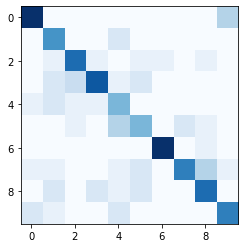

In [85]:
cm = confusion_matrix(y_test, y_pred)
print(cm)
plt.imshow(cm, cmap=plt.cm.Blues)

Come si può notare inserendo la Zero Crossing Rate calcolata con la seconda funzione (zerocrossingrate2) è possibile ottenere un incremento delle performance del modello di classificazione fino a raggiungere il 63% di Accuracy.